In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

from src.util import OneShotForecastingGoal
from src.pipeline import Use_ARMultiLayerPerceptronNeuralNetwork, Use_ARConvolutionalNeuralNetwork
from src.util import ForecastErrorEvaluation
from src.performer import MinMaxTransformer, SlidingWindowPerformer, DataFrameToSeriesTransformer

In [ ]:
input_sequence = 120

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
PROCESS STATUS                |  MODEL INFO                    |  RMSE INFO                     
Iterations:           302/302 |  Model: Multi Layer Perceptron |  Value:    0.1408008337020874  
Completation Status:  100%    |  Lag Variables: 1              |  Mean:     0.20604321360588074 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
SERIES INFO                                                                               
Test Series:[0.32369182 0.38101499 0.46962924 0.40888772 0.28477518]                        
X         [0.32369182]                                                                    
Y         [0.381015   0.46962923 0.4088877  0.28477517]                                   
YHAT      [0.28084794 0.25493163 0.22446051 0.2208637 ]                                   


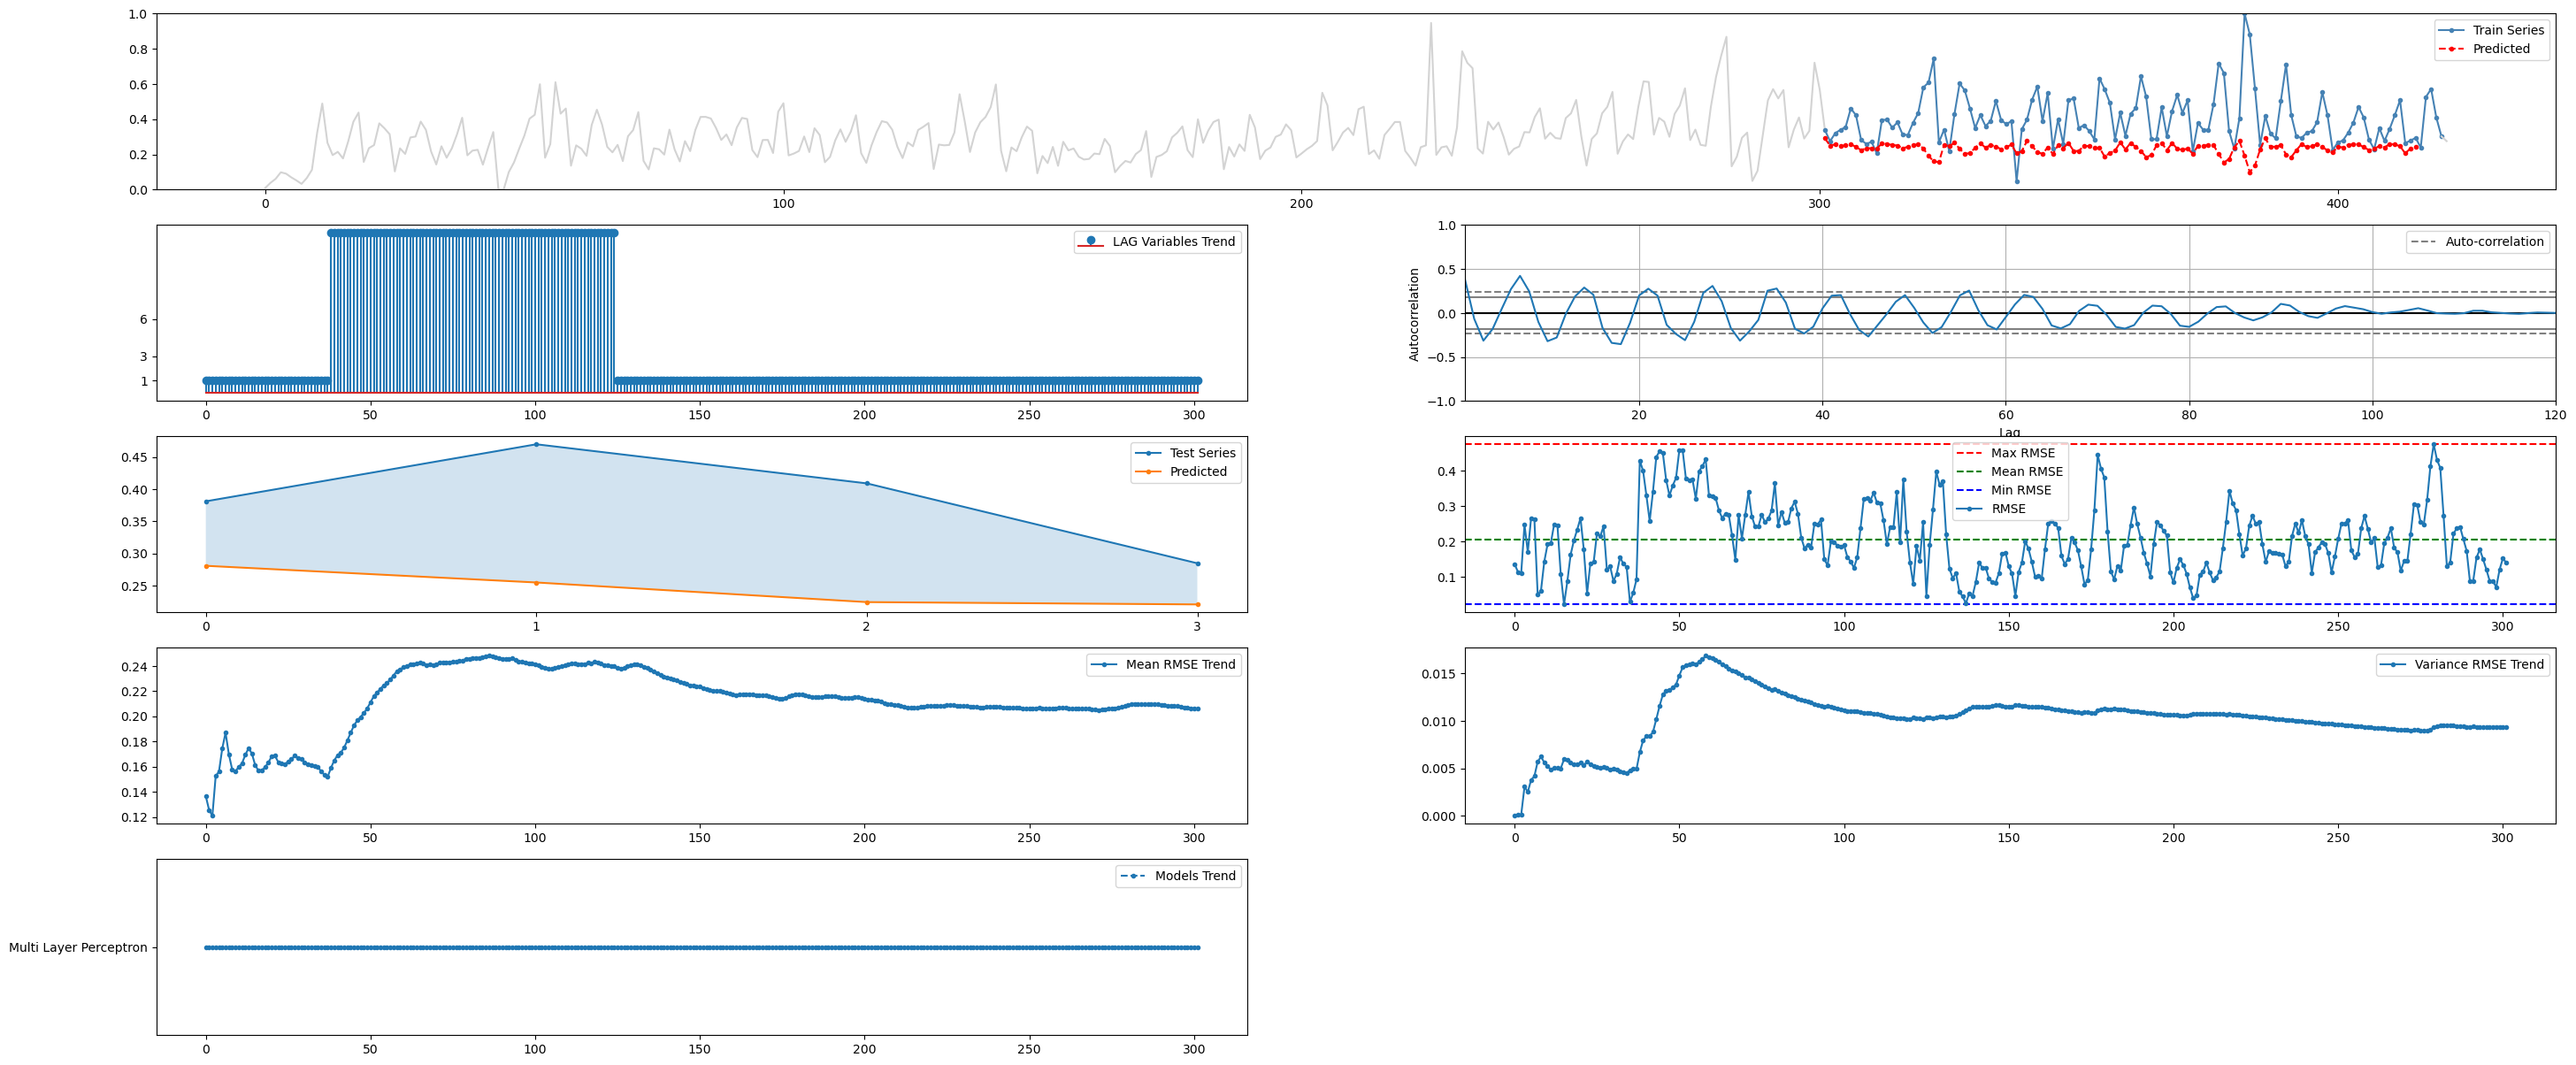

In [3]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("datasets/CASHPOINT_ID_5.csv")
goal = OneShotForecastingGoal(4)
FEE = ForecastErrorEvaluation(goal)
series = MinMaxTransformer.transform(df.SERIES1.to_numpy())
DFTS = DataFrameToSeriesTransformer()
loss_trend = []
variance_loss_trend = []
mean_loss_trend = []
lag_variables_trend = []
models_trend = []
iterations = series.shape[0] - input_sequence
for i in range(iterations):
    inner_series = series[i:i+input_sequence]
    train_series = inner_series[0:-19] ##View + Max LAg var
    test_series = inner_series[-19::] ##View + Max Lag Var

    model_MLP, parameters_MLP, loss_MLP = Use_ARMultiLayerPerceptronNeuralNetwork().__execute__(train_series, goal)
    # model_CNN, parameters_CNN, loss_CNN = Use_ARConvolutionalNeuralNetwork().__execute__(train_series, goal)
    # if(loss_MLP > loss_CNN):
    if(True):
        models_trend.append("Multi Layer Perceptron")
        model = model_MLP
        parameters = parameters_MLP
        loss = loss_MLP

        feature_length = parameters['feature_length']
        lag_variables_trend.append(feature_length)
        model.eval()
        with torch.no_grad():
            test_series = test_series[0:feature_length+4] ##View
            SWP = SlidingWindowPerformer(feature_length, 4, 1) ##View
            _, x, y = SWP.get(test_series)
            x = torch.tensor(x, dtype=torch.float32)
            yhat = model(x)
            yhat = yhat.detach().numpy()
            loss = FEE.get(y,yhat)

            loss_trend.append(loss)
            variance_loss_trend.append(np.var(np.array(loss_trend, dtype=np.float32)))
            mean_loss_trend.append(np.mean(loss_trend))
            yhat_show = yhat.flatten()
            y_show = y.flatten()

            #Predict Entire Series
            _, x_series, _ = SWP.get(inner_series)
            yhat_series = model(torch.tensor(x_series, dtype=torch.float32))
            series_predicted = DataFrameToSeriesTransformer.transform(yhat_series.detach().numpy())
            series_predicted = np.concatenate((series_predicted, np.array([None] * 5)), axis=0) ## View + 1
            
    # else:
    #     models_trend.append("Convolutional NN")
    #     model = model_CNN
    #     parameters = parameters_CNN
    #     loss = loss_CNN

    #     feature_length = parameters['feature_length']
    #     lag_variables_trend.append(feature_length)
    #     model.eval()
    #     with torch.no_grad():
    #         test_series = test_series[0:feature_length+4]
    #         SWP = SlidingWindowPerformer(feature_length, 4, 1)
    #         _, x, y = SWP.get(test_series)
    #         x = torch.tensor(x, dtype=torch.float32)
    #         yhat = model(x)
    #         yhat = yhat.detach().numpy()
    #         loss = FEE.get(y,yhat)

    #         loss_trend.append(loss)
    #         variance_loss_trend.append(np.var(np.array(loss_trend, dtype=np.float32)))
    #         mean_loss_trend.append(np.mean(loss_trend))
    #         yhat_show = yhat.flatten()
    #         y_show = y.flatten()


    
    plt.figure(figsize=(35,15))
    plt.margins(0.05)
    plt.subplot(511)
    plt.plot(np.arange(0,i+1,1), series[0:i+1], c='lightgrey')
    plt.plot(np.arange(i,i+input_sequence,1), series[i:i+input_sequence], c='steelblue', marker='o', markersize=3, label="Train Series")
    plt.plot(np.arange(i,i+series_predicted.shape[0],1), series_predicted, c='red', linestyle="--", marker='o', markersize=3, label="Predicted")
    plt.plot(np.arange(i+input_sequence-1, series.shape[0], 1), series[i+input_sequence-1::], c='lightgrey')
    plt.ylim([0.,1.])
    plt.legend()

    plt.subplot(523)
    plt.margins(0.05)
    plt.stem(lag_variables_trend)
    plt.yticks([1,3,6])
    plt.legend(["LAG Variables Trend"])

    plt.subplot(524)
    plt.margins(0.05)
    pd.plotting.autocorrelation_plot(inner_series)
    plt.legend(["Auto-correlation"])

    plt.subplot(525)
    plt.margins(0.05)
    plt.plot(y_show, marker='o', markersize=3)
    plt.plot(yhat_show, marker='o', markersize=3)
    plt.xticks(np.arange(0,4,1))
    plt.fill_between(x=np.arange(0,4,1), y1=y_show, y2=yhat_show, alpha=0.2)
    plt.legend(["Test Series", "Predicted"])
    
    plt.subplot(526)
    plt.margins(0.05)
    plt.axhline(y=np.max(loss_trend), c='red', linestyle='--')
    plt.axhline(y=np.mean(loss_trend), c='green', linestyle='--')
    plt.axhline(y=np.min(loss_trend), c='blue', linestyle='--')
    plt.plot(loss_trend, marker='o', markersize=3)
    plt.legend(["Max RMSE", "Mean RMSE", "Min RMSE", "RMSE"])

    plt.subplot(527)
    plt.margins(0.05)
    plt.plot(mean_loss_trend, marker='o', markersize=3)
    plt.legend(["Mean RMSE Trend"])

    plt.subplot(528)
    plt.margins(0.05)
    plt.plot(variance_loss_trend, marker='o', markersize=3)
    plt.legend(["Variance RMSE Trend"])

    plt.subplot(529)
    plt.margins(0.05)
    plt.plot(models_trend, marker='o', markersize=3, linestyle='--')
    plt.legend(["Models Trend"])

    
    clear_output(wait=True)

    print(''.join(['_ ' for i in range(50)]))
    print(f'{"PROCESS STATUS":<30}{"|":<3}{"MODEL INFO":<30}{"|":<3}{"RMSE INFO":<30}')
    print(f'{"Iterations:":<22}{str(i+1)+"/"+str(iterations):<8}{"|":<3}{"Model:":<7}{models_trend[-1]:<23}{"|":<3}{"Value:":<10}{loss:<20}')
    print(f'{"Completation Status:":<22}{str(int((i+1)/iterations*100))+"%":<8}{"|":<3}{"Lag Variables:":<15}{str(feature_length):<15}{"|":<3}{"Mean:":<10}{np.mean(loss_trend):<20}')
    print(''.join(['_ ' for i in range(50)]))
    print(f'{"SERIES INFO":<90}')
    print(f'{"Test Series:":<10}{str(test_series):<80}')
    print(f'{"X":<10}{str(x.detach().numpy().flatten()):<80}')
    print(f'{"Y":<10}{str(y_show):<80}')
    print(f'{"YHAT":<10}{str(yhat_show):<80}') 
    plt.show()

